In [1]:
import sys
import numpy as np
import cv2
import cv2.ml
from time import sleep
from datetime import datetime
import os
import numpy as np
from matplotlib import pyplot as plt
from pandas import read_csv, read_excel, DataFrame
#from sklearn.mixture import GaussianMixture
#from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
p = os.path.join('C:\\Users\\joaquin','usda','raw','CookIRCamET','Images','CookTests','HiRes')
p2 = os.path.join('C:\\Users\\joaquin','usda','work','CookIRCamET','Images','CookTests','HiRes')
n_feat = 4
n_components = 4

In [2]:
def localSD(mat, n):    
    mat=np.float32(mat)
    mu = cv2.blur(mat,(n,n))
    mdiff=mu-mat
    mat2=cv2.blur(np.float64(mdiff*mdiff),(n,n))
    sd = np.float32(cv2.sqrt(mat2))
    
    return sd

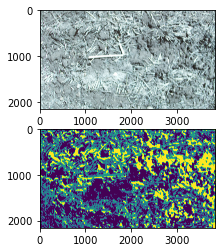

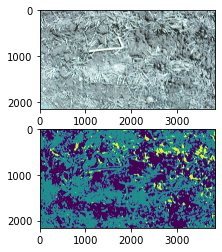

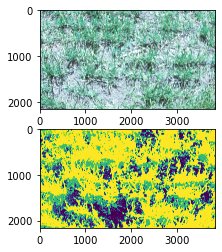

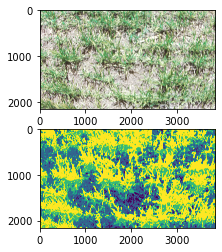

In [3]:
f_imgs=[]
test_imgs=[]
train_imgs=[]
for f in os.listdir(p):
    if 'bgr' in f:
        f_imgs = np.append(f_imgs,f)
        bgr = cv2.imread(os.path.join(p,f),cv2.IMREAD_UNCHANGED)
        f_labels = f.split('_bgr')[0]+'_labels.tif'
        labels = cv2.imread(os.path.join(p,f_labels),cv2.IMREAD_UNCHANGED)
        lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
        img = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        l,a,bb = cv2.split(lab)
        sd = localSD(l, 451)
        img_size = l.shape
        bb = bb.ravel()
        a = a.ravel()
        l = l.ravel()
        sd = sd.ravel()
        feat = np.vstack((l.T,a.T,bb.T,sd.T)).T
        plt.subplot(211)
        plt.imshow(bgr)
        plt.subplot(212)
        plt.imshow(labels)
        plt.show()
        #labels = np.sum(np.vstack((soil.ravel().T, residue.ravel().T*2, shadow.ravel().T*3, vegetation.ravel().T*4)).T,axis=1)
        labels = labels.ravel()
        if f.split('_')[0]=='20220509152045' or f.split('_')[0]=='20220509152630':
            train_imgs.append({'bgr':bgr,'feats':feat,'labels':labels})
        else:
            test_imgs.append({'bgr':bgr,'feats':feat,'labels':labels})

In [4]:
feats = []
labels = []
for sample in train_imgs:
    feats.append(sample['feats'])
    labels.append(sample['labels'])

In [5]:
for sample in test_imgs:
    feats.append(sample['feats'])
    labels.append(sample['labels'])

In [6]:
feats = np.array(feats).reshape((-1,n_feat)).astype(np.float32)
labels = np.array(labels).reshape((-1,1)).astype(np.int32)

In [7]:
data = cv2.ml.TrainData_create(feats,cv2.ml.ROW_SAMPLE,labels)
data.setTrainTestSplitRatio(.8,shuffle=True)
train_samples = data.getTrainSamples()
train_responses = data.getTrainResponses()
test_samples = data.getTestSamples()
test_responses = data.getTestResponses()

In [ ]:
model_rt = cv2.ml.RTrees_create()
model_rt.setMaxCategories(4)
model_rt.setMaxDepth(4)
model_rt.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6))
model_rt.train(train_samples,cv2.ml.ROW_SAMPLE,train_responses)
pred_rt = model_rt.predict(test_samples)

In [ ]:
model_em  = cv2.ml.EM_create()
model_em.setClustersNumber(4)
model_em.setCovarianceMatrixType(cv2.ml.EM_COV_MAT_DIAGONAL)
model_em.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6))
model_em.train(train_samples,cv2.ml.ROW_SAMPLE,train_responses)
pred_em = model_em.predict(test_samples)

In [ ]:
pred_rt

In [ ]:
cv2.CV